In [20]:
# Initialize Otter
import otter
grader = otter.Notebook("lab09.ipynb")

# Lab 9: Climate data, CO2 and `xarray`

## Due Date

This assignment is due on **October 25th, 2022, at 11:59PM PDT**.

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

This lab accompanies a lecture for Berkeley's Data 100 that covers the fundamental physical mechanisms behind global warming and analyzes CO2 and ocean temperature data.

Authors: Fernando Pérez and [Dr. Chelle Gentemann](https://cgentemann.github.io).

**Collaborators:** *list names here*

In [21]:
# Run this cell to set up your notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

## Loading the Mauna Loa CO2 data

We start by loading the same dataset we used during the lecture, containing CO2 measurements in Mauna Loa, Hawaii.

In [22]:
# Set up to load data either from the shared directory that has the complete set,
# or from the local small copy available in the repo

DATA_DIR = Path('./data')

# If you want to run this on the Berkeley data hub, where we have a larger version of the data,
# uncomment the below. But do not do that for submitting the Lab, as the version that will
# run on the grader needs to use the path above and only has enough data to grade the Lab.
#DATA_DIR = Path.home()/Path('shared/climate-data')

Now we start by loading the CO2 data from a CSV file:

In [23]:
co2_file = DATA_DIR / "monthly_in_situ_co2_mlo_cleaned.csv"
data = pd.read_csv(co2_file)
data.shape

(768, 10)

In [24]:
# get rid of missing values that are set to -99.99 and then drop from the dataset
data = pd.read_csv(co2_file, na_values=-99.99).dropna()
data.head()

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
6,1958,7,21381,1958.5370,315.86,315.19,315.86,315.22,315.86,315.19
7,1958,8,21412,1958.6219,314.93,316.19,313.99,315.29,314.93,316.19


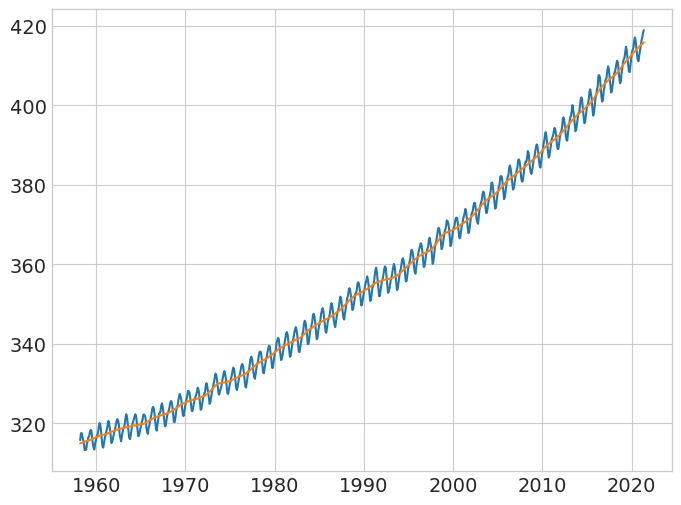

In [25]:
# We did this in lecture, as a reminder this is what the data looks like:
plt.plot("fraction_date", "c02", data=data)
plt.plot("fraction_date", "data_adjusted_seasonally_fit", data=data);

# Exploring the annual anomaly

Notice how in the plot, there seems to be oscilliations within each year (changing by the months/seasons), but the overall trend of these oscillations appears to be going upward. We are going to try to understand the annual variability on top of the underlying growing trend, and see whether that variability within a given year is itself changing over time or not.

The figure above shows an annual cycle, alongside with perhaps some variability in it. As we saw in lecture (recall the super computer movie in talk with cities release of co2 strongest in winter), plants take up CO2 in (northern) spring/summer then release in fall/winter --- so the release is getting stronger. 

The annual cycles look a bit like waves, and recall that the amplitude of a wave is the height of its peak. Let's try to estimate the increase in amplitude of annual cycle over the years.

<!-- why would using a rolling mean make it look like the cycle is getting larger - both summer/winter rather than just winter? with this data can you figure out if summer or winter causing increase? -->

In the lecture notebook, we created the following figure, based on a quick and simple groupby operation and removal of the annual mean:

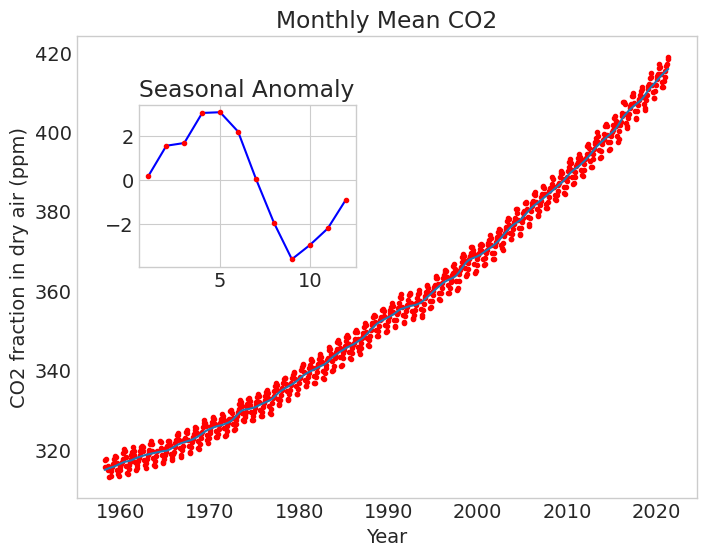

In [26]:
# calculate the annual cycle using groupby
annual = data.groupby(data.month).mean()
# calculate the anomaly
anomaly = annual - annual.mean() # something that deviates from what is standard

# plot
fig, ax = plt.subplots()

ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
axin1.plot(anomaly.c02, "b")
axin1.plot(anomaly.c02, "r.")
axin1.set_title("Seasonal Anomaly");

But if you look closely, that figure isn't quite the same as the one shown in slide 9 of the lecture:

<img src="annual-anomaly-orig.png" width="700px" />

We'll start by trying to understand the monthly data. The following shows us the data for all the years, by month:

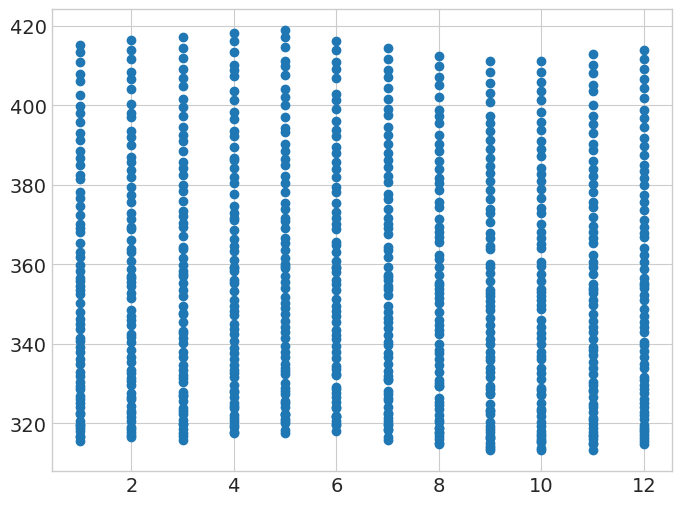

In [27]:
plt.scatter('month', 'c02', data=data);

Unfortunately it's hard to see what's actually going on here.

### Question 1

Recreate the following figure, that shows the monthly cycle for all the years in the dataset:

<img src="monthly-cycles-co2.png" width="700px" />

Hint: Use `sns.lineplot(...)`


/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='month', ylabel='c02'>

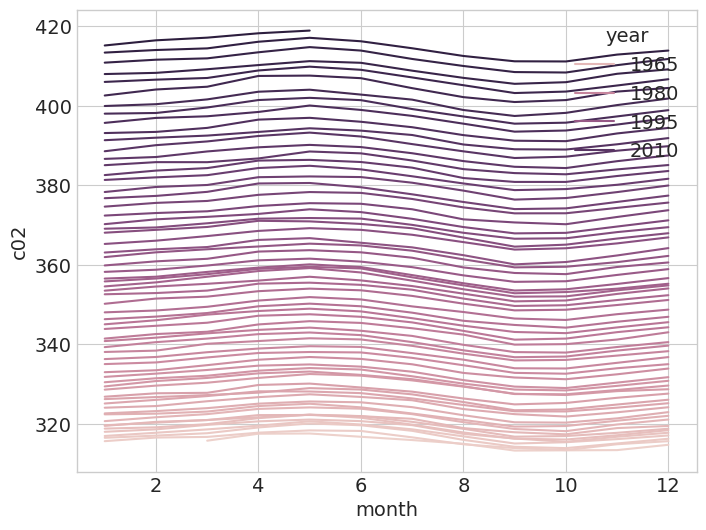

In [28]:
sns.lineplot('month', 'c02', data=data, hue='year')

### Question 2

Next, in order to attempt to recreate the figure in the talk, we're going to find the monthly anomaly averaging across year. To find this anomaly, we will first be "detrending" our data: we will be taking our data for each year, and subtracting off the mean from that year to get a sense of the variability about the average for each year. After detrending, we'll average the monthly data across all years. In this question, you will be writing code to detrend the data. You should end up with the following data frame after writing your function and running the cell (only the first few months are shown, it should have data for all 12 months):

<img src="monthly-co2-anomaly-df.png" width="150px" />


In [29]:
def detrend(f):
    detrended_xarr = f['c02'] - f['c02'].mean()
    f['c02'] = detrended_xarr
    return f
    

dy = data.groupby('year')
c02anomaly = dy.apply(detrend)
display(c02anomaly)
monthly_anomaly = c02anomaly.groupby('month').mean()[['c02']]
monthly_anomaly

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
2,1958,3,21259,1958.2027,0.3675,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,2.1175,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,2.1775,314.71,317.86,315.06,317.51,314.71
6,1958,7,21381,1958.5370,0.5275,315.19,315.86,315.22,315.86,315.19
7,1958,8,21412,1958.6219,-0.4025,316.19,313.99,315.29,314.93,316.19
...,...,...,...,...,...,...,...,...,...,...
756,2021,1,44211,2021.0411,-2.0180,415.11,415.24,415.17,415.17,415.11
757,2021,2,44242,2021.1260,-0.7180,415.70,416.13,415.35,416.47,415.70
758,2021,3,44270,2021.2027,-0.0480,415.59,417.06,415.50,417.14,415.59
759,2021,4,44301,2021.2877,1.0520,415.44,418.48,415.66,418.24,415.44


,c02
month,
1,-0.683835
2,0.076121
3,0.874238
4,2.240270
5,2.864155
6,2.299297
7,0.792919
8,-1.195018
9,-2.851367


In [30]:
grader.check("q2")

q2 results: All test cases passed!

### Question 3

Next, recreate the following figure, which is much closer to the one in the lecture:

<img src="annual-anomaly-new.png" width="700px" />

**Hints:** 
- in order to get that smooth curve, you'll need to use `from scipy.interpolate import CubicSpline`. You can find the documentation for `CubicSpline` [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html). Cubic splines are a very useful method to interpolate data between points (i.e., to draw a function connecting multiple points so we get a better idea of what the function may look like in between points). As an extra hint on using CubicSpline, it's implementation is quite similar to any sci-kit learn function you've already used.
- The "Seasonal Anomaly" inset graph can be created with `ax.inset_axes(...)`. You can treat the `Axes` object returned like any other `Axes` object.
- Remember that you can set the tick labels with `ax.set_xticks(...)`.
- To get the data points plotted as red dots, when you use `ax.plot(...)`, pass in `"r."` as the argument immediately following any data you pass in. The `"r"` indicates the color, while the `"."` indicates how the data will be plotted (if you don't put the `"."`, it will be a line instead).


In [31]:
print(c02anomaly)

     year  month  date_index  fraction_date     c02  data_adjusted_season  \
2    1958      3       21259      1958.2027  0.3675                314.43   
3    1958      4       21290      1958.2877  2.1175                315.16   
4    1958      5       21320      1958.3699  2.1775                314.71   
6    1958      7       21381      1958.5370  0.5275                315.19   
7    1958      8       21412      1958.6219 -0.4025                316.19   
..    ...    ...         ...            ...     ...                   ...   
756  2021      1       44211      2021.0411 -2.0180                415.11   
757  2021      2       44242      2021.1260 -0.7180                415.70   
758  2021      3       44270      2021.2027 -0.0480                415.59   
759  2021      4       44301      2021.2877  1.0520                415.44   
760  2021      5       44331      2021.3699  1.7320                415.50   

     data_fit  data_adjusted_seasonally_fit  data_filled  \
2      316.19  

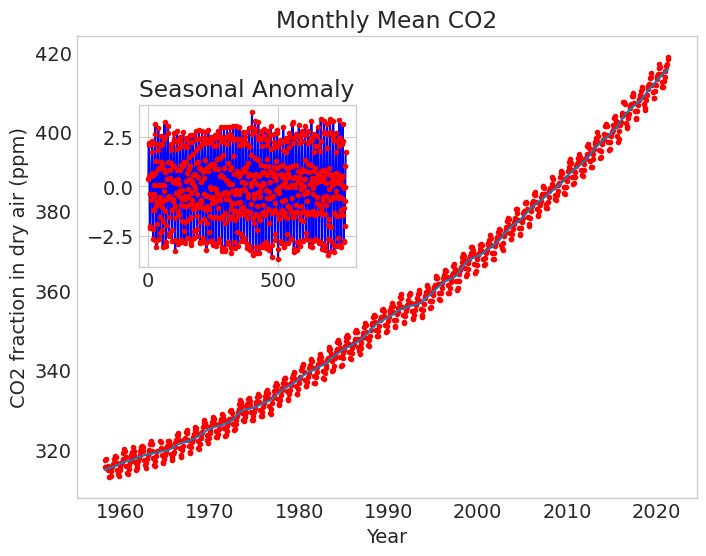

In [32]:
from scipy.interpolate import CubicSpline

fig, ax = plt.subplots()

ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
axin1.plot(c02anomaly.c02, "b")
axin1.plot(c02anomaly.c02, "r.")
axin1.set_title("Seasonal Anomaly");

# Exploring Snow with ERA 5

Now, we turn our attention to the global ERA 5 dataset and explore some other questions - it's a very rich and interesting dataset, and the lecture only scratched its surfac!

We are going today to focus on just one more bit: we'll take a look at the snow accumulation data for the northern and southern hemispheres.

But you should see this as an invitation to keep learning from these data! Think of looking at other variables in the dataset. Is there annual cycle? trend? Some of the data might look very different than the air temperature - eg. precipitation which is either 0 or +. Can you use PDFs to look at changes in distributions over a region? at a point? Or talk about the data a little & what you understand it is measuring? Are any of the data variables related to each other? Can you plot correlations between data?

In [33]:
import xarray as xr

monthly_2deg_path = DATA_DIR / "era5_snow_monthly_2deg_aws_v20210920.nc"

# The Berkeley hub has a version with not only snow data but many more variables.
# You can explore the full dataset by uncommenting the following if you are on the
# campus hub. Do NOT do that for your lab submission, as that data is NOT available
# on Gradescope.

# Use this version only when running on the hub:
# monthly_2deg_path = Path("~/shared/climate-data").expanduser() / "era5_monthly_2deg_aws_v20210920.nc"

ds = xr.open_dataset(monthly_2deg_path)
ds

<xarray.Dataset>
Dimensions:       (time: 504, latitude: 90, longitude: 180)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-16T11:30:00 ... 2020-12-16T11...
  * latitude      (latitude) float32 -88.88 -86.88 -84.88 ... 85.12 87.12 89.12
  * longitude     (longitude) float32 0.875 2.875 4.875 ... 354.9 356.9 358.9
Data variables:
    snow_density  (time, latitude, longitude) float32 ...

Consider a standard `pandas` DataFrame, where each observation has an integer index and each column contains variable information about that observation. For physical data, we often have data that is collected at points at a particular location on Earth at a particular time. We can think of this data as being indexed by three-dimensions: longitude, latitude, and time. This part of the lab uses a package called `xarray`, a package with a very similar functionality as `pandas`, but is much more versatile in that it allows a user to work easily with such data that may have multidimensional indexing.

What we just made above was called an `xarray.Dataset` object, a collection of a bunch of `xarray.DataArray` objects. Intuitively, a single `xarray.DataArray` object contains measurements of a single variable indexed across different locations in space and time, and multiple `xarray.DataArray` objects for different variables can be grouped into a single `xarray.Dataset` for easier bookkeeping/organization.

`xarray` also has a really neat interactive feature when you print out a `Dataset` or a `DataArray`: you can click to see the different Dimensions of the dataset, the Coordinates that data points are collected at (in space, given by latitude/longitude combinations, and time), and variable information collected at each point in space and time (Data variables). 

Feel free to click around on the above output! When cliking the rightmost button for `time`, `latitude`, and `longitude` coordinates, we see that each of these are actually just NumPy arrays, giving us the latitudes/longitudes as well as times that our observations were collected! The Data variables section always tells you what variables you are collecting information about at each of these latitude-longitude-time coordinates. Here, we are collecting information about snow density, at different points in space across time.

`xarray` has a rich documentation, so you can always check there if you have questions. However, when in doubt, using a `Pandas` type implementation to get something done might work since the packages are so similar. For example, if I wanted all of the unique longitudes in my dataset, I could just do the following, which spits out a DataArray of my longitudes.

In [34]:
ds['longitude']

<xarray.DataArray 'longitude' (longitude: 180)>
array([  0.875,   2.875,   4.875,   6.875,   8.875,  10.875,  12.875,  14.875,
        16.875,  18.875,  20.875,  22.875,  24.875,  26.875,  28.875,  30.875,
        32.875,  34.875,  36.875,  38.875,  40.875,  42.875,  44.875,  46.875,
        48.875,  50.875,  52.875,  54.875,  56.875,  58.875,  60.875,  62.875,
        64.875,  66.875,  68.875,  70.875,  72.875,  74.875,  76.875,  78.875,
        80.875,  82.875,  84.875,  86.875,  88.875,  90.875,  92.875,  94.875,
        96.875,  98.875, 100.875, 102.875, 104.875, 106.875, 108.875, 110.875,
       112.875, 114.875, 116.875, 118.875, 120.875, 122.875, 124.875, 126.875,
       128.875, 130.875, 132.875, 134.875, 136.875, 138.875, 140.875, 142.875,
       144.875, 146.875, 148.875, 150.875, 152.875, 154.875, 156.875, 158.875,
       160.875, 162.875, 164.875, 166.875, 168.875, 170.875, 172.875, 174.875,
       176.875, 178.875, 180.875, 182.875, 184.875, 186.875, 188.875, 190.875,
       192.875, 194.875, 196.875, 198.875, 200.875, 202.875, 204.875, 206.875,
       208.875, 210.875, 212.875, 214.875, 216.875, 218.875, 220.875, 222.875,
       224.875, 226.875, 228.875, 230.875, 232.875, 234.875, 236.875, 238.875,
       240.875, 242.875, 244.875, 246.875, 248.875, 250.875, 252.875, 254.875,
       256.875, 258.875, 260.875, 262.875, 264.875, 266.875, 268.875, 270.875,
       272.875, 274.875, 276.875, 278.875, 280.875, 282.875, 284.875, 286.875,
       288.875, 290.875, 292.875, 294.875, 296.875, 298.875, 300.875, 302.875,
       304.875, 306.875, 308.875, 310.875, 312.875, 314.875, 316.875, 318.875,
       320.875, 322.875, 324.875, 326.875, 328.875, 330.875, 332.875, 334.875,
       336.875, 338.875, 340.875, 342.875, 344.875, 346.875, 348.875, 350.875,
       352.875, 354.875, 356.875, 358.875], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.875 2.875 4.875 6.875 ... 354.9 356.9 358.9
Attributes:
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

We can imagine we have snow density measurements across three axes: latitude, longitude, and time. If we take all measurements for a particular time (let's say, year), we would have data on snow measurements for each latitude and longitudes for that particular year, a snapshot in time of the worldwide snow density. However, let's suppose we wish to get the snow density measurements for each latitude and longitude, averaged across all the times in the dataset. We are essentially then aggregating over time, such that each latitude/longitude location now only has one snow density measurement: the average over all the years for that location.

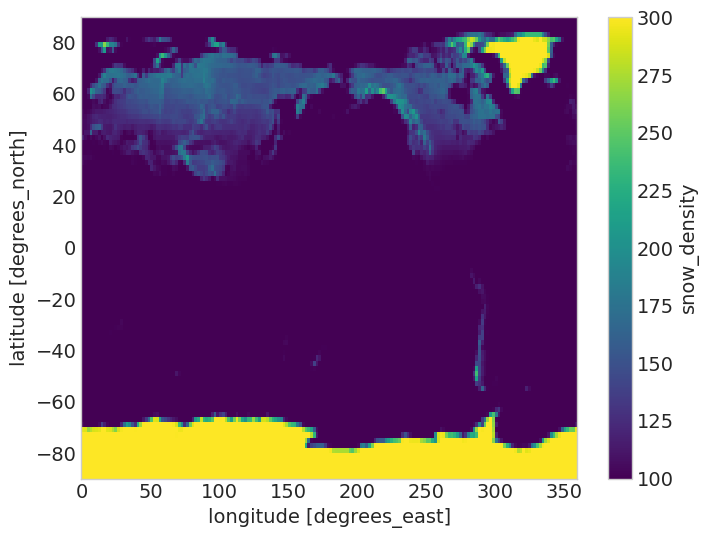

In [35]:
mean_map = ds.mean("time")  # takes the mean across all variables in ds
mean_map.snow_density.plot();

We can also extract the `snow_density` information from our `xarray.Dataset` to return a `xarray.DataArray`, in the same way we might take a column from a `pandas.DataFrame`. Once again, the output is interactive, so it's really helpful to understand what exactly is contained in this dataset. Provided below is the snow density measurements are given in the from of numpy arrays stacked on top of each other. 

Consider for a second why this data structure makes sense: stacked numpy arrays are three-dimensional NumPy arrays, or collections of numbers indexed by three numbers as opposed to just two in a standard array or one as in a list. Snow density measurements are given across three dimensions (time, latitude, longitude), so the numpy array with this information should be three dimensional. 

Once again, `xarray` tells us what each axis of this numpy array means (time, latitude, and longitude), and also gives us some information in the Attributes section, such as the units `snow_density` is measured in.

In [36]:
snow = ds.snow_density
snow

<xarray.DataArray 'snow_density' (time: 504, latitude: 90, longitude: 180)>
array([[[300., 300., ..., 300., 300.],
        [300., 300., ..., 300., 300.],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]],

       [[300., 300., ..., 300., 300.],
        [300., 300., ..., 300., 300.],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]],

       ...,

       [[300., 300., ..., 300., 300.],
        [300., 300., ..., 300., 300.],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]],

       [[300., 300., ..., 300., 300.],
        [300., 300., ..., 300., 300.],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-16T11:30:00 ... 2020-12-16T11:30:00
  * latitude   (latitude) float32 -88.88 -86.88 -84.88 ... 85.12 87.12 89.12
  * longitude  (longitude) float32 0.875 2.875 4.875 6.875 ... 354.9 356.9 358.9
Attributes:
    long_name:       Snow density
    nameCDM:         Snow_density_surface
    nameECMWF:       Snow density
    product_type:    analysis
    shortNameECMWF:  rsn
    standard_name:   snow_density
    units:           kg m**-3

### Question 4

Let's look at the snow density measurements across the globe in February and August, respectively. Februrary is considered the peak of winter in the Northern Hemisphere and the peak of summer in the Southern Hemisphere, and vice versa for August.

Recreate the following figure, along with a corresponding one for August 1980. 

*Hint:* using the `snow` variable above, which is an `xarray.Dataset` object of snow density measurements across time and location, how can you extract all of the measurements for February 1980? for August 1980? See [this page](https://docs.xarray.dev/en/stable/user-guide/indexing.html) from the `xarray` documentation about how to index into these objects (try to avoid the methods where you use integer indexing, the beauty of `xarray` is it's label indexing!) For plotting, try to see if there are any similarities with plotting in `pandas` DataFrames.

<img src="snow-distribution-1980-02.png" width="500px" />


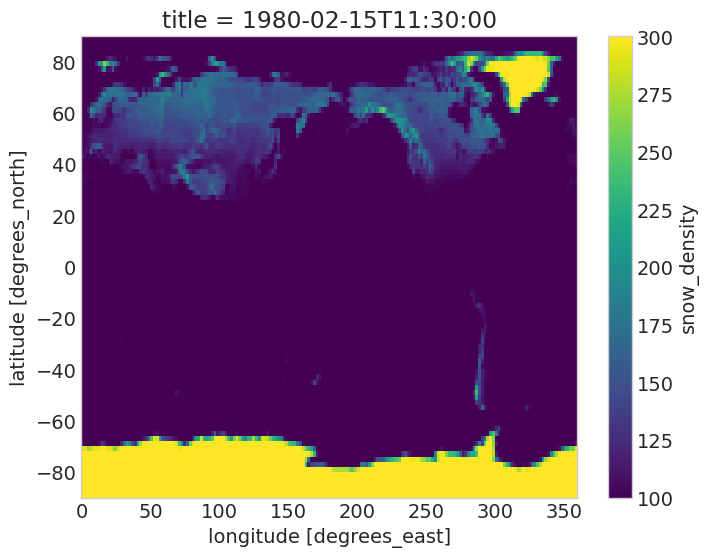

In [56]:
mean_map = snow.mean("time")
mean_map.plot()
plt.title('title = 1980-02-15T11:30:00');

In [ ]:
mean_map = snow.mean("time")
mean_map.plot()
plt.title('title = 1980-02-15T11:30:00');

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)